In [ ]:
!pip install 'pymc3 ==3.8'
!pip install 'arviz ==0.8.3'
!pip install 'statsmodels == 0.11.1'
!pip install 'scipy'

     |████████████████████████████████| 911kB 3.1MB/s 
     |████████████████████████████████| 1.5MB 18.4MB/s 
     |████████████████████████████████| 4.3MB 35.0MB/s 
     |████████████████████████████████| 296kB 44.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 1.5MB 3.3MB/s 
  Found existing installation: arviz 0.9.0
    Uninstalling arviz-0.9.0:
      Successfully uninstalled arviz-0.9.0
     |████████████████████████████████| 8.7MB 3.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import theano
import arviz as az
from scipy.stats import norm
from scipy.special import logsumexp
plt.style.use('fivethirtyeight')

### Code 6.1

In [ ]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


### Code 6.2

In [ ]:
m6_1 = smf.ols('brain ~ mass', data=d).fit()

### Code 6.3

In [ ]:
1 - m6_1.resid.var()/d.brain.var()

0.490158047949084

### Code 6.4

In [ ]:
m6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

### Code 6.5

In [ ]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

### Code 6.6

In [ ]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

### Code 6.7

In [ ]:
d_new = d.drop(d.index[-1])

### Code 6.8

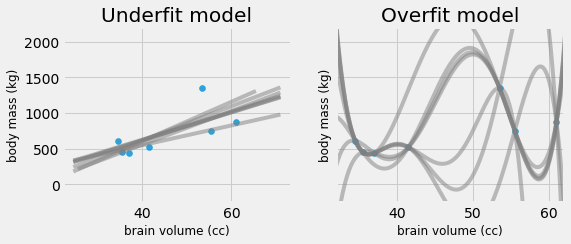

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()


### Code 6.9

In [ ]:
p = [0.3,0.7]
- np.sum(p*np.log(p))

0.6108643020548935

### Code 6.10

In [ ]:

# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.92498968588757

### Code 6.11

In [ ]:
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(2000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:06<00:00, 1041.36it/s]


In [ ]:
theta = az.summary(m_6_8)['mean'][:3]

In [ ]:
d['brain']

0     438
1     452
2     612
3     521
4     752
5     871
6    1350
Name: brain, dtype: int64

In [ ]:
#compute deviance
dev = - 2 * sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1] * d['mass_s']  , scale = theta[2]))
dev

100.59815020340247

###Code 6 .12

In [ ]:
# N = 20
# k=6
# rho=[0.15, -0.4]
# n_dim = 1 + len(rho)
# print(n_dim)
# if n_dim < k:
#     n_dim = k
# print(n_dim)
# Rho = np.diag(np.ones(n_dim))
# Rho[0, 1:3:1] = rho
# i_lower = np.tril_indices(n_dim, -1)
# Rho[i_lower] = Rho.T[i_lower]

# x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
# x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

# mm_train = np.ones((N,1))

#np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

#Using pymc3

# with pm.Model() as m_sim:
#     vec_V = pm.MvNormal('vec_V', mu=0, cov=100 * np.eye(n_dim), 
#                         shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
#     mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
#     y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
#     trace_m_sim = pm.sample(2000, tune=5000)

#x_train
# vec=az.summary(trace_m_sim)['mean'][0:n_dim]
# print(vec)
# vec = np.array([i for i in vec]).reshape(n_dim, -1)
# print(vec)
# x_train[:, 0]
# vec = pm.summary(trace_m_sim)['mean'][:n_dim]
# vec = np.array([i for i in vec]).reshape(n_dim, -1)

# dev_train = stats.norm.logpdf(x_train[:,0], loc = np.matmul(x_train, vec), scale = 1)

# # x_train = stats.multivariate_normal.rvs(cov=Rho, size=10000)
# # np.cov(x_train,rowvar=False)
# x_train.shape

In [ ]:
# This function only works with number of parameters >= 2 

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    mm_train = np.ones((N,1))
    
    #np.concatenate([mm_train, x_train[:, 1:k]], axis=1)
    
    #Using pymc3
    
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        trace_m_sim = pm.sample(2000, tune=5000)


    # with m_sim:
    #     trace_m_sim = pm.sample()
        
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    dev_train = - 2 * sum(stats.norm.logpdf(x_train[:,0], loc = np.matmul(x_train, vec), scale = 1))    
    
    mm_test = np.ones((N,1))
    
    mm_test = np.concatenate([mm_test, x_test[:, 1:k +1]], axis=1)
    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    
    
    return np.mean(dev_train), np.mean(dev_test)

### Code 6.13

In [ ]:
n = 20
tries = 1
param = 6
r = np.zeros(shape=(param - 1, 4))
train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [vec_V]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:09<00:00, 744.00it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vec_V]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:08<00:00, 794.01it/s]


4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vec_V]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:09<00:00, 714.21it/s]


5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vec_V]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:09<00:00, 725.55it/s]


6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [vec_V]
Sampling chain 1, 0 divergences: 100%|██████████| 7000/7000 [00:10<00:00, 681.06it/s]


### Code 6.14

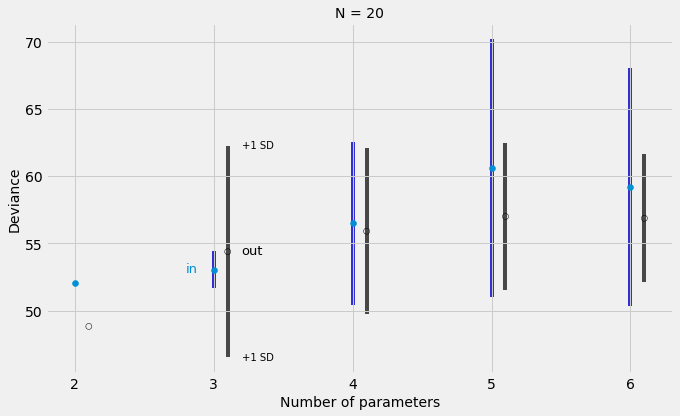

In [ ]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title('N = {}'.format(n), fontsize=14)
plt.show()

### Code 6.15

In [ ]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/cars.csv'
cars = pd.read_csv(url,sep=',', header=0)
data = cars.iloc[:,[1,2]]
display(data.head())

with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(500, tune=10000)

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 10500/10500 [00:16<00:00, 633.20it/s]


### Code 6.16

In [ ]:
ll = stats.norm.logpdf(np.repeat(data['dist'][np.newaxis,:], 1000,0),
                         loc = m_6_15['mu'] ,
                         scale = np.repeat(m_6_15['sigma'][:,np.newaxis], 50,1))
print(ll.shape)


(1000, 50)


### Code 6.17

In [ ]:
n_samples = 1000
lppd = logsumexp(ll,axis=0) -  np.log(n_samples)

## Alternate way of getting lppd
# ll =stats.norm.pdf(np.repeat(data['dist'][np.newaxis,:], 1000,0),
#                          loc = m_6_15['mu'] ,
#                          scale = np.repeat(m_6_15['sigma'][:,np.newaxis], 50,1))
# lppd = np.log(np.mean(lppd,axis=0))
print(lppd.shape)
print(sum(lppd))

(50,)
-206.6166667002688


### Code 6.18

In [ ]:
pWAIC= np.var(ll,axis =0)
print(sum(pWAIC))

3.4954924697911496


### Code 6.19

In [ ]:
-2 * (np.sum(lppd) - np.sum(pWAIC))

420.2243183401199

### Code 6.20

In [ ]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(data.shape[0] * np.var(waic_vec))

12.730074519378862

### Code 6.21

In [ ]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv'
d = pd.read_csv(url,sep=';', header=0)
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

(17, 9)

### Code 6.22

In [ ]:
a_start = d['kcal.per.g'].mean()
sigma_start = np.log(d['kcal.per.g'].std())
mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    log_sigma = pm.Normal('log_sigma',mu=0,sd=10, testval= sigma_start)
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd= np.exp(log_sigma), observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)   

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    log_sigma = pm.Normal('log_sigma',mu=0,sd=10, testval= sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=np.exp(log_sigma), observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(1000, tune=1000)

with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    log_sigma = pm.Normal('log_sigma',mu=0,sd=10, testval= sigma_start)
    mu = alpha + beta * mass_shared
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=np.exp(log_sigma), observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)

with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    log_sigma = pm.Normal('log_sigma',mu=0,sd=10, testval= sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=np.exp(log_sigma), observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(5000, tune=15000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1548.24it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 221.42it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1029.16it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma, beta, alpha]
Sampling chain 1, 3 divergences: 100%|██████████| 20000/20000 [02:28<00:00, 135.09it/s]
There were 15 divergences after tuning. Increase `target_accept` or re

### Code 6.23

In [ ]:
az.waic(trace_m6_14, m6_14,scale = 'deviance')

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1411: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 10000 by 17 log-likelihood matrix

              Estimate       SE
deviance_waic   -17.14     5.31
p_waic            3.16        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

### Code 6.24

In [ ]:
compare_df = az.compare({'m6_11' : trace_m6_11,
                         'm6_12' : trace_m6_12,
                         'm6_13' : trace_m6_13,
                         'm6_14' : trace_m6_14}, method='pseudo-BMA',ic="WAIC",scale = 'deviance')
compare_df

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1411: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6_14,0,-17.1414,3.15938,0,0.956909,5.30572,0,True,deviance
m6_13,1,-9.45185,1.9855,7.68959,0.0204691,4.40007,3.62376,True,deviance
m6_11,2,-8.84503,1.3892,8.29641,0.0151122,3.8995,5.0366,False,deviance
m6_12,3,-7.44652,1.97946,9.69491,0.00751012,3.3924,5.14295,False,deviance


### Code 6.25

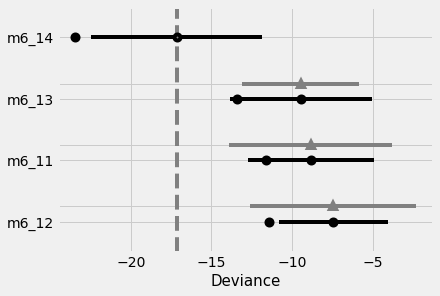

In [ ]:
az.plot_compare(compare_df);

### Code 6.26

In [ ]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff < 0) / 100000

0.17958

### Code 6.27

In [ ]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

,m6_11,m6_12,m6_13,m6_14
alpha,0.658,0.394,0.704,-1.049
beta,NaN,0.387,-0.031,NaN
beta[0],NaN,NaN,NaN,-0.095
beta[1],NaN,NaN,NaN,2.736
log_sigma,-1.727,-1.702,-1.760,-2.027


### Code 6.28

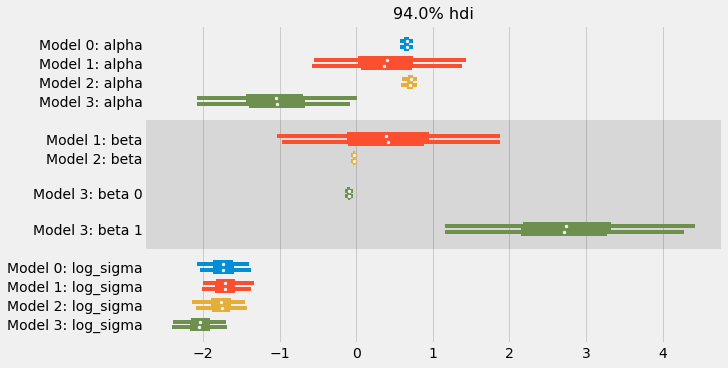

In [ ]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]
az.plot_forest(traces, figsize=(10, 5));

### Code 6.29

In [ ]:
kcal_per_g = np.repeat(0, 30)  # empty outcome
neocortex = np.linspace(0.5, 0.8, 30)  # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_posterior_predictive(trace_m6_14, samples=10000, model=m6_14)

100%|██████████| 10000/10000 [00:29<00:00, 340.21it/s]


In [ ]:
milk_ensemble = pm.sample_posterior_predictive_w(traces, 10000, 
                                                 models,
                                                 weights=compare_df.weight.sort_index(ascending=True))

100%|██████████| 10000/10000 [00:27<00:00, 359.32it/s]


/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (10000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (10000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,


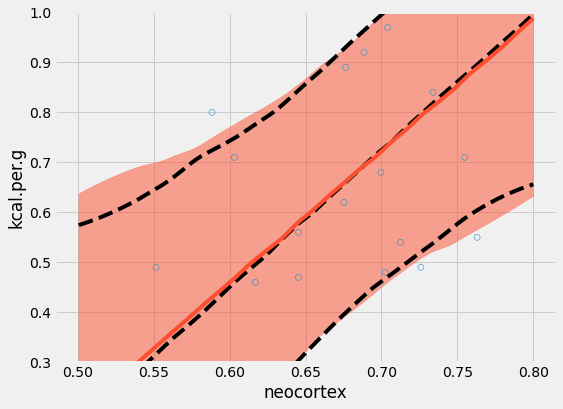

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal_per_g'].mean(0), ls='--', color='k')
az.plot_hdi(neocortex, post_pred['kcal_per_g'],
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})

plt.plot(neocortex, milk_ensemble['kcal_per_g'].mean(0), color='C1')
az.plot_hdi(neocortex, milk_ensemble['kcal_per_g'])

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex')
plt.ylabel('kcal.per.g');